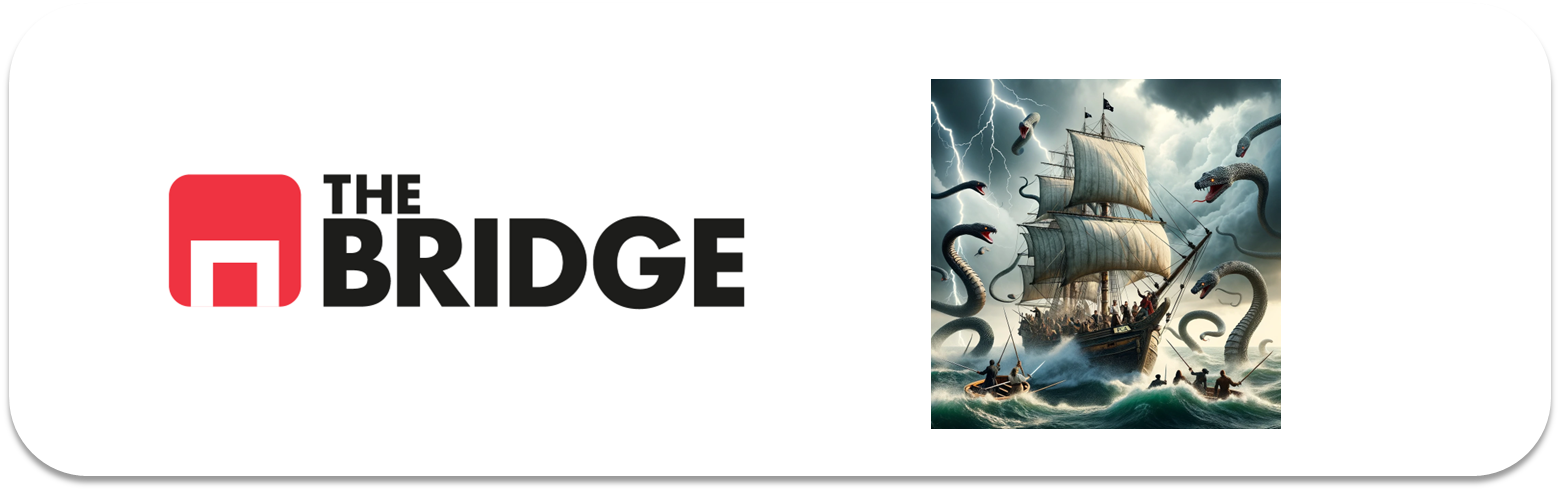

## PRACTICA OBLIGATORIA: **No Supervisado: PCA**

* La práctica obligatoria de esta unidad consiste en aplicar PCA a un dataset de imágenes con diferentes objetivos y compromisos. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### El problema de negocio

El Caesar Palace de las Vegas está planificando la instalación de mil quininetas microcámaras en los accesos a sus instalaciones para las próximas sesiones del "Poker World Championship". Estas microcámaras tienen la peculiaridad de que son capaces de tomar fotos encuadradas de las caras y la desventaja de que no tienen un gran ancho de banda de comunicación. (Las había de más ancho y de mayor precio...). NOTA: El ancho de banda limita el tamaño de las imágenes que pueden enviar las microcámaras).

El objetivo de las microcámaras es el de detectar personas "non-gratas" en tiempo real, pudiendo posprocesar las imágenes para poder detectar si han accedido a las instalaciones personas que estuvieran perseguidas por la ley, en los bancos de datos de los casinos identificadas como "peligrosas" (no se sabe si para el resto de personas o para los beneficios de los casinos) y en las listas de no admisión de jugadores adictos. Por eso no necesitan procesar los datos en tiempo real, pero sí enviarlos a un repositorio central. 

¿Cuál es su problema? O bien comprimen las imágenes y las procesan comprimidas en cada microcámara (pueden comprimir muy rápido pero no tienen cpu para procesarlas sin comprimir) o bien las comprimen y las mandan a un servidor central muy rápido (por eso ti) donde se descomprimirían y se analizarían. Analizar quiere decir en este contexto, pasarles un modelo de clasificación que determine si la persona de la imagen es una de las listas prohibidas (o sea que clasifique la imágen).  

Nos han enviado un dataset y con él debemos estudiar cuál de las dos soluciones es más interesante y dar recomendaciones al respecto. Vamos a ello.

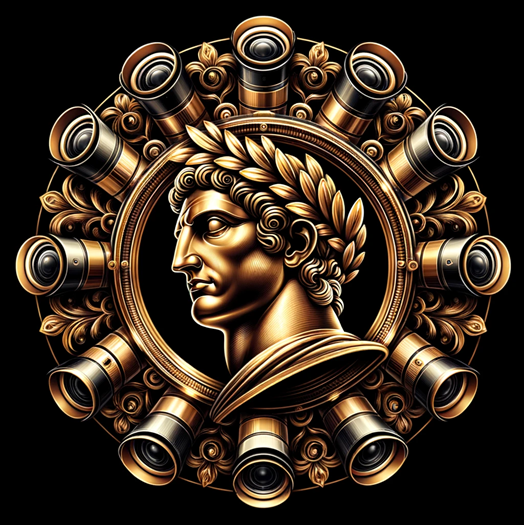

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [23]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline



### #1 MODELO DE BASE

**Objetivo:** Construir un modelo baseline de clasficación de imágenes que las trate sin comprimir (es decir usando todos sus píxeles).

Para conseguir el objetivo, primero descarga el dataset de las caras de Olivetti que ya has utilizado anteriormente, empleando las funciones de sklearn necesarias. Luego, construye un clasificador con el modelo que consideres más apropiado y todas las features del dataset. Eso sí, recuerda hacer lo siguiente:

1. Construir un data frame con los datos 
2. Hacer un split en train y test con al menos 80 instancias en el test y estratificado según el target. Este split se ha de mantener en el resto de la práctica
3. Hacer un quick miniEDA o justificar el no hacerlo.
4. Medir la recall media (“balanced_accuracy”) sobre cross validation con 5 folds y sobre el conjunto de test y guarda ambas para usarlas como baseline en las siguientes partes




In [9]:
# Descargar el dataset de las caras de Olivetti
data = fetch_olivetti_faces()
images = data.images
targets = data.target

In [4]:
# Convertir las imágenes a un DataFrame
n_samples, h, w = images.shape
X = images.reshape((n_samples, h * w))
df = pd.DataFrame(X)
df['target'] = targets

In [5]:
# Mostrar las primeras filas del DataFrame
print(df.head())

          0         1         2         3         4         5         6  \
0  0.309917  0.367769  0.417355  0.442149  0.528926  0.607438  0.657025   
1  0.454545  0.471074  0.512397  0.557851  0.595041  0.640496  0.681818   
2  0.318182  0.400826  0.491736  0.528926  0.586777  0.657025  0.681818   
3  0.198347  0.194215  0.194215  0.194215  0.190083  0.190083  0.243802   
4  0.500000  0.545455  0.582645  0.623967  0.648760  0.690083  0.694215   

          7         8         9  ...      4087      4088      4089      4090  \
0  0.677686  0.690083  0.685950  ...  0.669421  0.652893  0.661157  0.475207   
1  0.702479  0.710744  0.702479  ...  0.157025  0.136364  0.148760  0.152893   
2  0.685950  0.702479  0.698347  ...  0.132231  0.181818  0.136364  0.128099   
3  0.404959  0.483471  0.516529  ...  0.636364  0.657025  0.685950  0.727273   
4  0.714876  0.723140  0.731405  ...  0.161157  0.177686  0.173554  0.177686   

       4091      4092      4093      4094      4095  target  
0  0.1

In [11]:
# Hacer un split en train y test con al menos 80 instancias en el test y estratificado según el target
X_train, X_test, y_train, y_test = train_test_split(X, targets, test_size=80, stratify=targets, random_state=42)

In [12]:
# Verificar las dimensiones de los conjuntos de datos
print(f'Tamaño del conjunto de entrenamiento: {X_train.shape[0]}')
print(f'Tamaño del conjunto de prueba: {X_test.shape[0]}')

Tamaño del conjunto de entrenamiento: 320
Tamaño del conjunto de prueba: 80


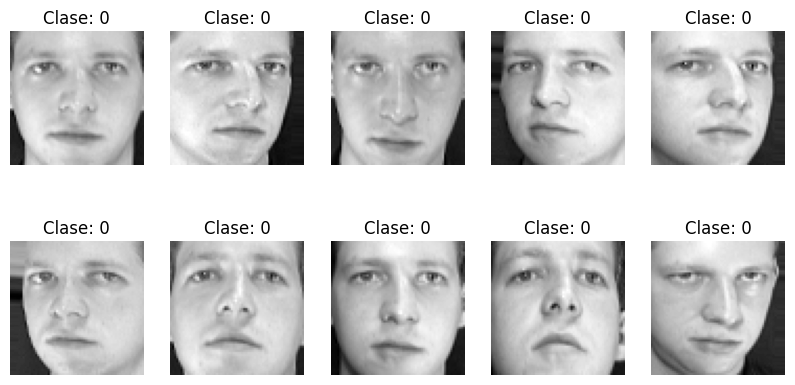

In [14]:
# Visualizar algunas imágenes del dataset
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f'Clase: {targets[i]}')
    ax.axis('off')
plt.show()

In [16]:
# Construir el clasificador SVM
clf = SVC(kernel='linear', random_state=42)

In [17]:
# Evaluar el clasificador utilizando cross-validation con 5 folds
cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='balanced_accuracy')
print(f'Recall media (cross-validation): {cv_scores.mean()}')

Recall media (cross-validation): 0.9625


In [18]:
# Entrenar el clasificador en el conjunto de entrenamiento
clf.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [19]:
# Evaluar el clasificador en el conjunto de prueba
y_pred = clf.predict(X_test)
test_score = balanced_accuracy_score(y_test, y_pred)
print(f'Recall media (test): {test_score}')

Recall media (test): 0.975


### #2 MODELO PARA LAS MICROCÁMARAS
**Objetivo:** Construir un modelo que pueda funcionar en las microcámaras, es decir que pueda funcionar con datos comprimidos.

Para cumplir con el objetivo se os ocurre emplear la doble propiedad de la PCA, que permite comprimir datos y mantener la capacidad informativa de estos. Sigue los siguientes pasos:
1. Instancia un objeto PCA sobre los datos de Train sin especificar ni componentes ni varianza explicada (o sea sin pasar argumentos).
2. Escoge un rango de valores para el número de PCAs que permitan por lo menos una compresión de la imagen de entre el 0.2% y el 2.5% (prueba al menos 5 valores). NOTA: La compresión es la reducción total, es decir una reducción del 1% quiere decir que el dataset se reduce a un 1% de su tamaño original)
3. Para el rango anterior entrena un modelo de clasificación y apunta su scoring en una validación cruzada de 5 folds y métrica el recall medio y su scoring contra test.
4. Muestra en un dataframe el valor de numero de componentes principales empleado, el scoring en CV, el scoring contra test, el % de compresión, la diferencia con el scoring de CV del modelo base, la diferencia con el scoring en test.
5. Escoge el número de componentes que permitirían tener la mayor compresión con una pérdida inferior a 3 puntos porcentuales tanto en CV como en test. Si no hay escoge el que tenga una pérdida inferior a 5 puntos porcentuales. 

In [21]:
# Instanciar un objeto PCA sin especificar ni componentes ni varianza explicada
pca = PCA()

In [22]:
# Definir el rango de valores para el número de componentes principales
n_features = X_train.shape[1]
compression_ratios = [0.002, 0.005, 0.01, 0.015, 0.025]
n_components_list = [int(n_features * ratio) for ratio in compression_ratios]
print(f'Número de componentes principales: {n_components_list}')

Número de componentes principales: [8, 20, 40, 61, 102]


In [25]:
results = []

# Definir las variables de referencia del modelo base
baseline_cv_score = cv_scores.mean()  # Recall media (cross-validation) del modelo base
baseline_test_score = test_score  # Recall media (test) del modelo base

for n_components in n_components_list:
    # Crear un pipeline con PCA y SVM
    pca = PCA(n_components=n_components)
    clf = SVC(kernel='linear', random_state=42)
    pipeline = Pipeline([('pca', pca), ('svm', clf)])
    
    # Evaluar el modelo utilizando cross-validation con 5 folds
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='balanced_accuracy')
    cv_mean_score = cv_scores.mean()
    
    # Entrenar el modelo en el conjunto de entrenamiento
    pipeline.fit(X_train, y_train)
    
    # Evaluar el modelo en el conjunto de prueba
    y_pred = pipeline.predict(X_test)
    test_score = balanced_accuracy_score(y_test, y_pred)
    
    # Calcular el porcentaje de compresión
    compression_percentage = (n_components / n_features) * 100
    
    # Guardar los resultados
    results.append({
        'n_components': n_components,
        'cv_score': cv_mean_score,
        'test_score': test_score,
        'compression_percentage': compression_percentage,
        'cv_diff': baseline_cv_score - cv_mean_score,
        'test_diff': baseline_test_score - test_score
    })

In [27]:
# Convertir los resultados a un DataFrame
results_df = pd.DataFrame(results)
results_df

,n_components,cv_score,test_score,compression_percentage,cv_diff,test_diff
0,8,0.8250,0.8250,0.195312,0.0000,0.0000
1,20,0.9475,0.9375,0.488281,-0.1225,-0.1125
2,40,0.9575,0.9625,0.976562,-0.1325,-0.1375
3,61,0.9575,0.9750,1.489258,-0.1325,-0.1500
4,102,0.9625,0.9750,2.490234,-0.1375,-0.1500


In [28]:
# Escoger el número de componentes principales óptimo
optimal_results = results_df[(results_df['cv_diff'] <= 0.03) & (results_df['test_diff'] <= 0.03)]
if optimal_results.empty:
    optimal_results = results_df[(results_df['cv_diff'] <= 0.05) & (results_df['test_diff'] <= 0.05)]

In [29]:
# Escoger la configuración con la mayor compresión
optimal_result = optimal_results.loc[optimal_results['compression_percentage'].idxmax()]
print(f'Configuración óptima:\n{optimal_result}')

Configuración óptima:
n_components              102.000000
cv_score                    0.962500
test_score                  0.975000
compression_percentage      2.490234
cv_diff                    -0.137500
test_diff                  -0.150000
Name: 4, dtype: float64


### #3 COMPRESION PARA CLASIFICACION POSTERIOR

**Objetivo**: Obtener el número de componentes que permita una compresión menor y al tiempo que el modelo en el servidor central no baje su rendimiento respecto a no usar imágenes comprimidas.

Para esta parte la idea que se os ha ocurrido es emplear también la PCA como compresor ya que así siempre podrían pasar a la opción anterior si eso fuese suficiente. Pero en este caso no vamos a utilizar el dataset comprimido con las PCAs para detectar las caras, sino el dataset una vez descomprimido (recuerda que puede emplear `inverse_transform` para "descomprimir"). Los pasos a seguir son:

1. Escoge un rango de valores que  permitan una compresión aún mayor (recuerda que el ancho de banda es mínimo) entre el 1 por mil y el 1 por ciento. Escoge 5 valores de número de PCAs que permitan movernos en ese rango.
2. Para cada uno de esos valores: aplica la PCA al X_train, obten un X_train_unzipped aplicando la inversa de la PCA y entrena un modelo de clasificación y pruébalo contra test, apunta el balanced accuracy.
3. Crea un dataframe o haz un visualización comparando como es la medidad de balance accuracy para cada valor de número de pcas escogido y cuál su factor de compresión. 
4. Sabiendo que no podemos perder más de 3 puntos porcentuales respecto al baseline, ¿qué numero de PCA escogerías?

In [30]:
# Definir el rango de valores para el número de componentes principales
compression_ratios = [0.001, 0.0025, 0.005, 0.0075, 0.01]
n_components_list = [int(n_features * ratio) for ratio in compression_ratios]
print(f'Número de componentes principales: {n_components_list}')

Número de componentes principales: [4, 10, 20, 30, 40]


In [31]:
results = []

for n_components in n_components_list:
    # Crear un objeto PCA con el número de componentes especificado
    pca = PCA(n_components=n_components)
    
    # Aplicar PCA al conjunto de entrenamiento
    X_train_compressed = pca.fit_transform(X_train)
    
    # Obtener el conjunto descomprimido
    X_train_unzipped = pca.inverse_transform(X_train_compressed)
    
    # Crear y entrenar el clasificador SVM
    clf = SVC(kernel='linear', random_state=42)
    clf.fit(X_train_unzipped, y_train)
    
    # Evaluar el modelo en el conjunto de prueba
    X_test_compressed = pca.transform(X_test)
    X_test_unzipped = pca.inverse_transform(X_test_compressed)
    y_pred = clf.predict(X_test_unzipped)
    test_score = balanced_accuracy_score(y_test, y_pred)
    
    # Calcular el porcentaje de compresión
    compression_percentage = (n_components / n_features) * 100
    
    # Guardar los resultados
    results.append({
        'n_components': n_components,
        'test_score': test_score,
        'compression_percentage': compression_percentage,
        'test_diff': baseline_test_score - test_score
    })

# Convertir los resultados a un DataFrame
results_df = pd.DataFrame(results)
print(results_df)

   n_components  test_score  compression_percentage  test_diff
0             4      0.5250                0.097656     0.3000
1            10      0.9000                0.244141    -0.0750
2            20      0.9375                0.488281    -0.1125
3            30      0.9625                0.732422    -0.1375
4            40      0.9625                0.976562    -0.1375


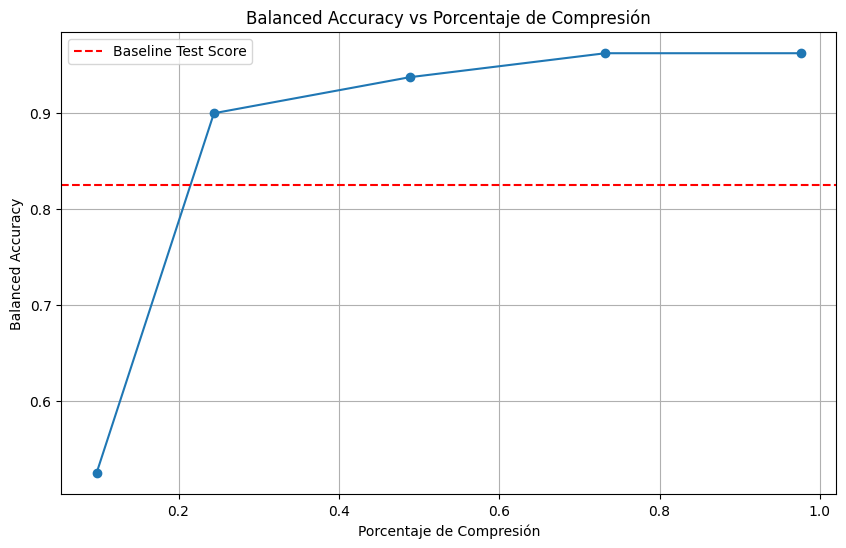

In [32]:
# Crear una visualización de los resultados
plt.figure(figsize=(10, 6))
plt.plot(results_df['compression_percentage'], results_df['test_score'], marker='o', linestyle='-')
plt.axhline(y=baseline_test_score, color='r', linestyle='--', label='Baseline Test Score')
plt.xlabel('Porcentaje de Compresión')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy vs Porcentaje de Compresión')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# Filtrar los resultados para encontrar la mejor configuración
optimal_results = results_df[results_df['test_diff'] <= 0.03]

# Escoger la configuración con la mayor compresión
optimal_result = optimal_results.loc[optimal_results['compression_percentage'].idxmax()]
print(f'Configuración óptima:\n{optimal_result}')

Configuración óptima:
n_components              40.000000
test_score                 0.962500
compression_percentage     0.976562
test_diff                 -0.137500
Name: 4, dtype: float64


### #EXTRA

1. Para la segunda parte, visualiza en cuatro gráficos un scatter plot de las dos primeras componentes principales de la PCA escogida y colorea cada punto con las clases correspondientes a cada cara (como hay 40 clases, usa 10 por gráfico, 1-10 en el primero, 11-20 en el segundo, etc)
2. Para la tercer parte crea una función (modifica la de la práctica de la unidad de KMeans, por ejemplo) que permita ver la cara sin comprimir y la cara después de haberla descomprimido y haz una comprobación de cómo quedan (visualiza 5 caras por ejemplo) para cada uno de los valores de números de PCAs probados. Añade el caso para 150 y 300 PCs para que se vea que son las mismas claras con claridad.

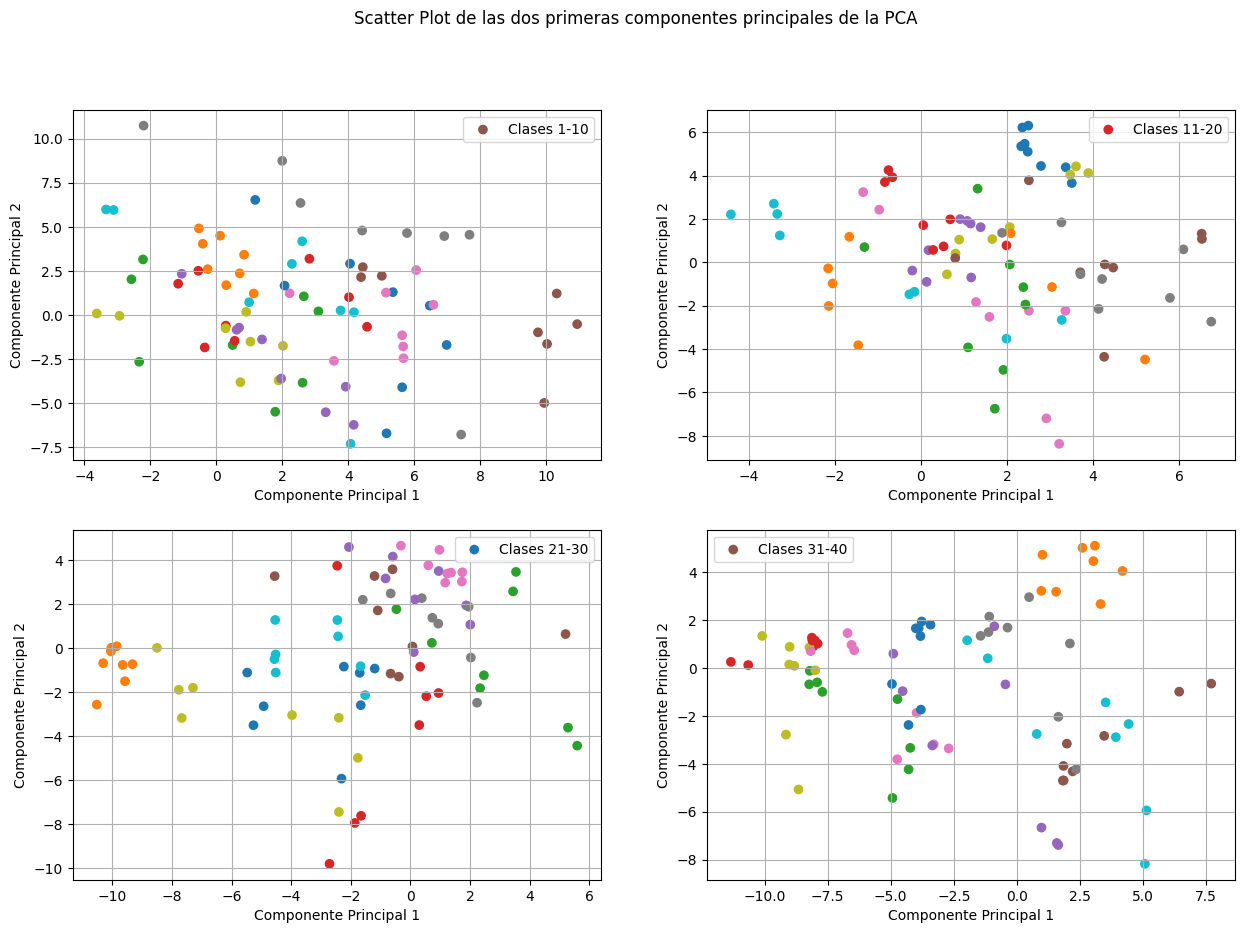

In [35]:
# Aplicar PCA con el número de componentes óptimo
optimal_n_components = int(optimal_result['n_components'])
pca_optimal = PCA(n_components=optimal_n_components)
X_train_pca = pca_optimal.fit_transform(X_train)

# Crear scatter plots para las dos primeras componentes principales
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, ax in enumerate(axes.ravel()):
    start_class = i * 10
    end_class = (i + 1) * 10
    mask = (y_train >= start_class) & (y_train < end_class)
    scatter = ax.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], c=y_train[mask], cmap='tab10', label=f'Clases {start_class+1}-{end_class}')
    ax.set_xlabel('Componente Principal 1')
    ax.set_ylabel('Componente Principal 2')
    ax.legend()
    ax.grid(True)

plt.suptitle('Scatter Plot de las dos primeras componentes principales de la PCA')
plt.show()

Visualización para 4 componentes principales:


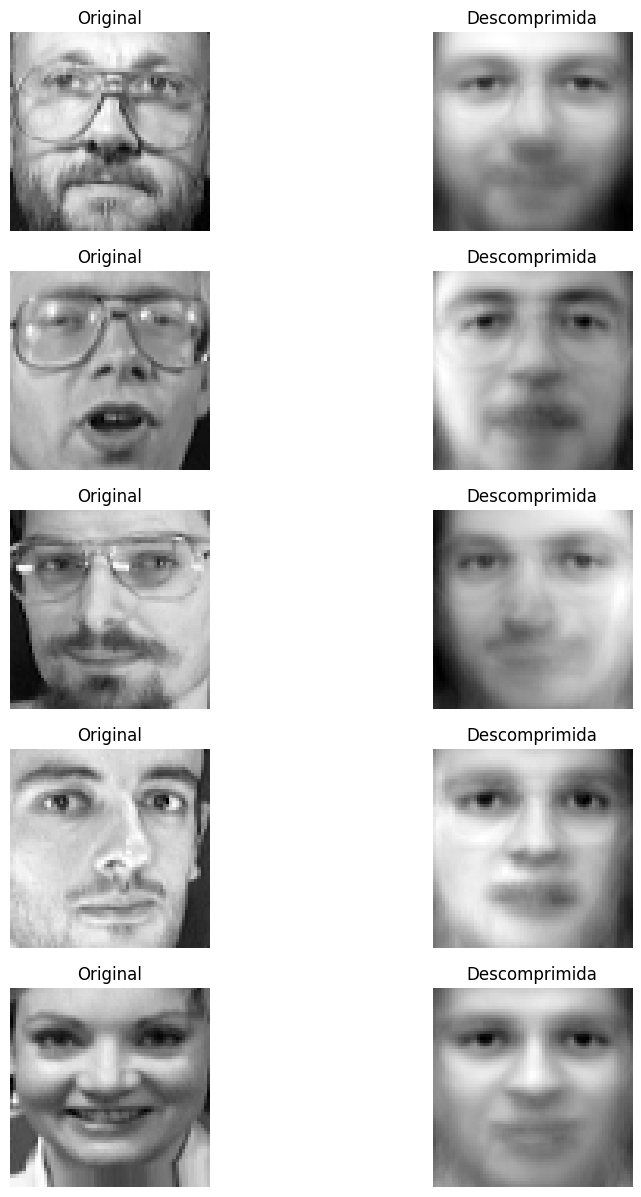

Visualización para 10 componentes principales:


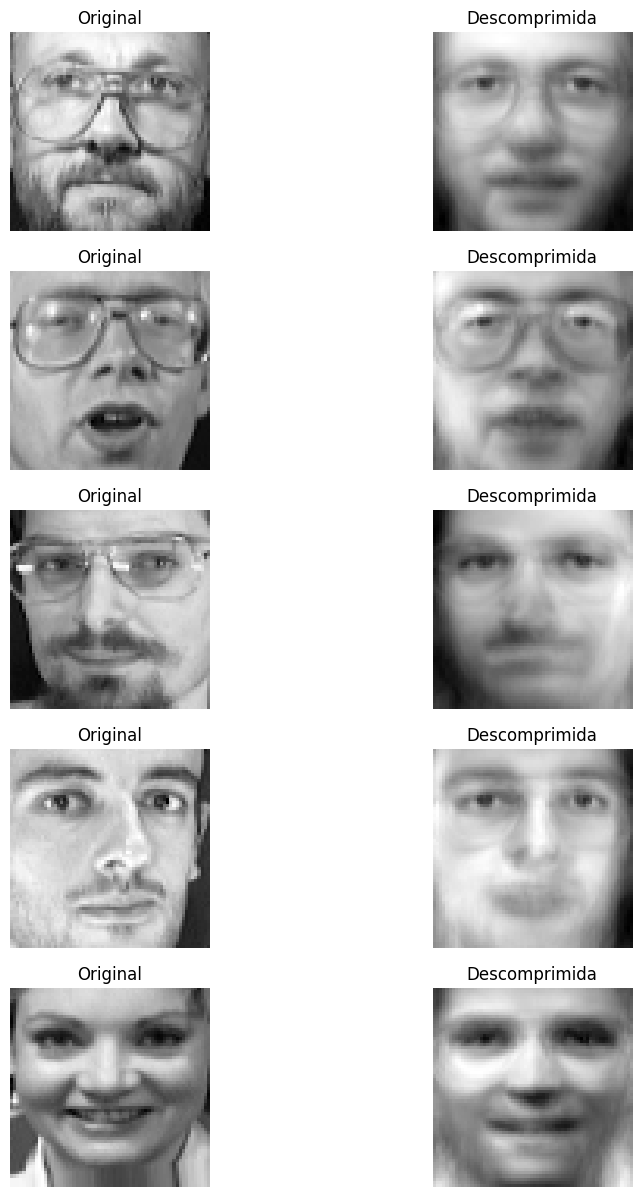

Visualización para 20 componentes principales:


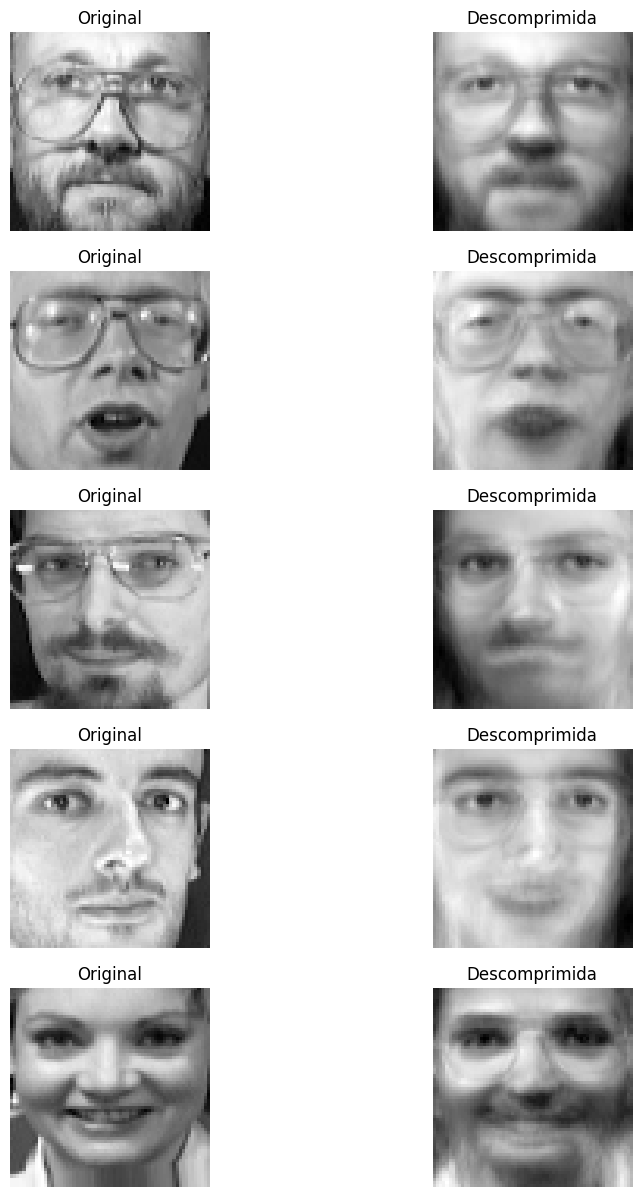

Visualización para 30 componentes principales:


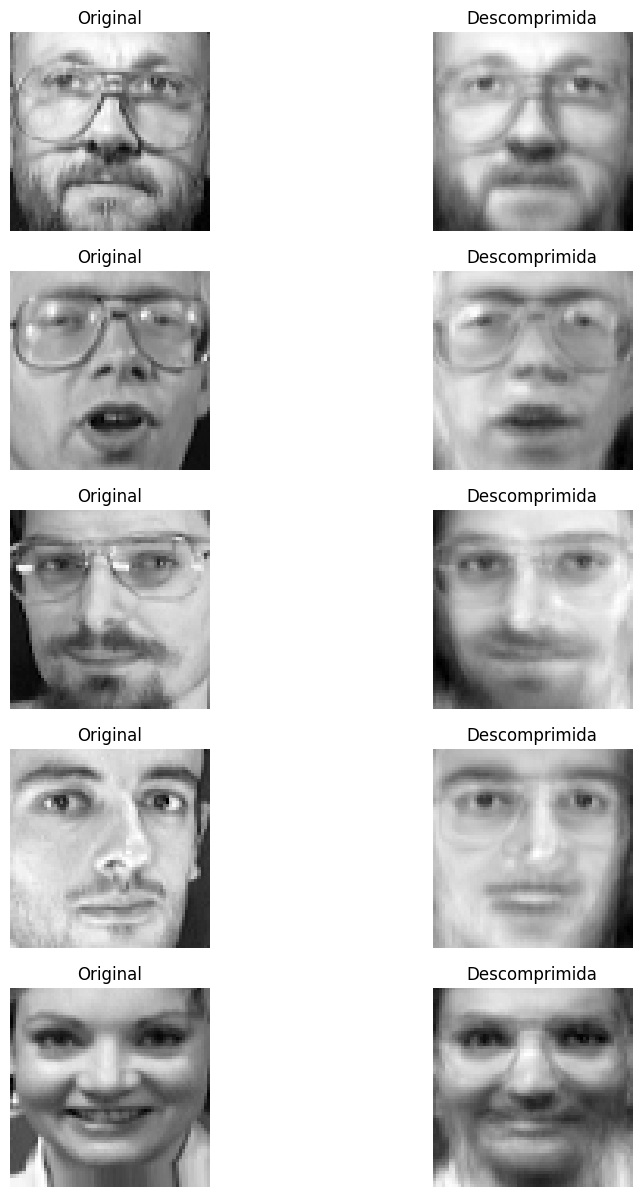

Visualización para 40 componentes principales:


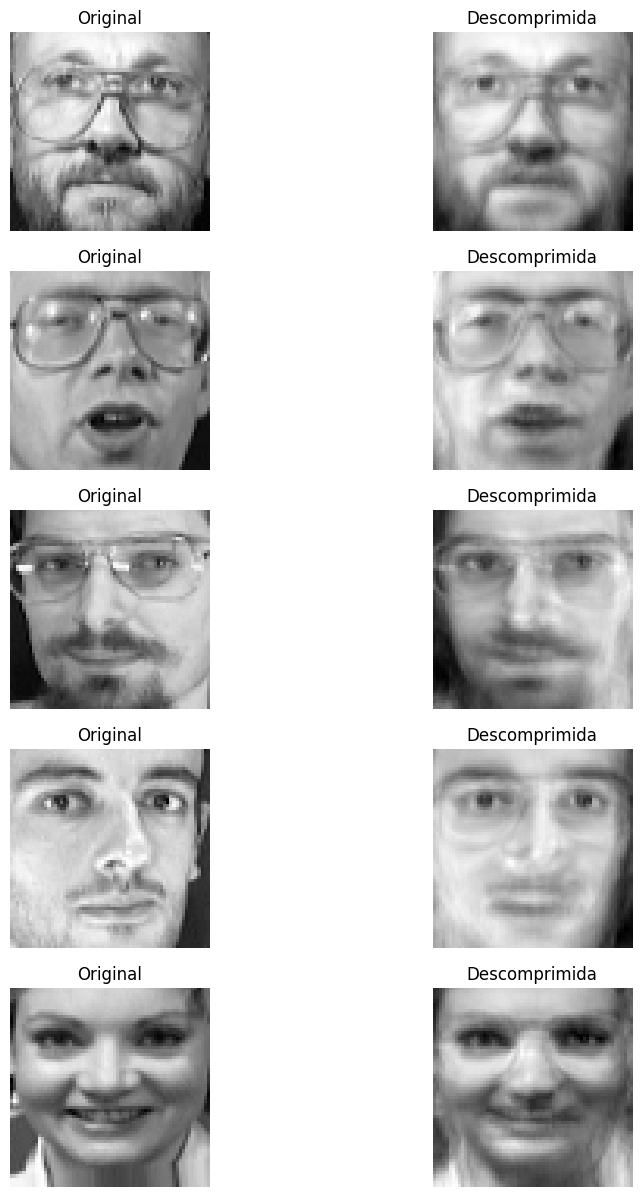

Visualización para 150 componentes principales:


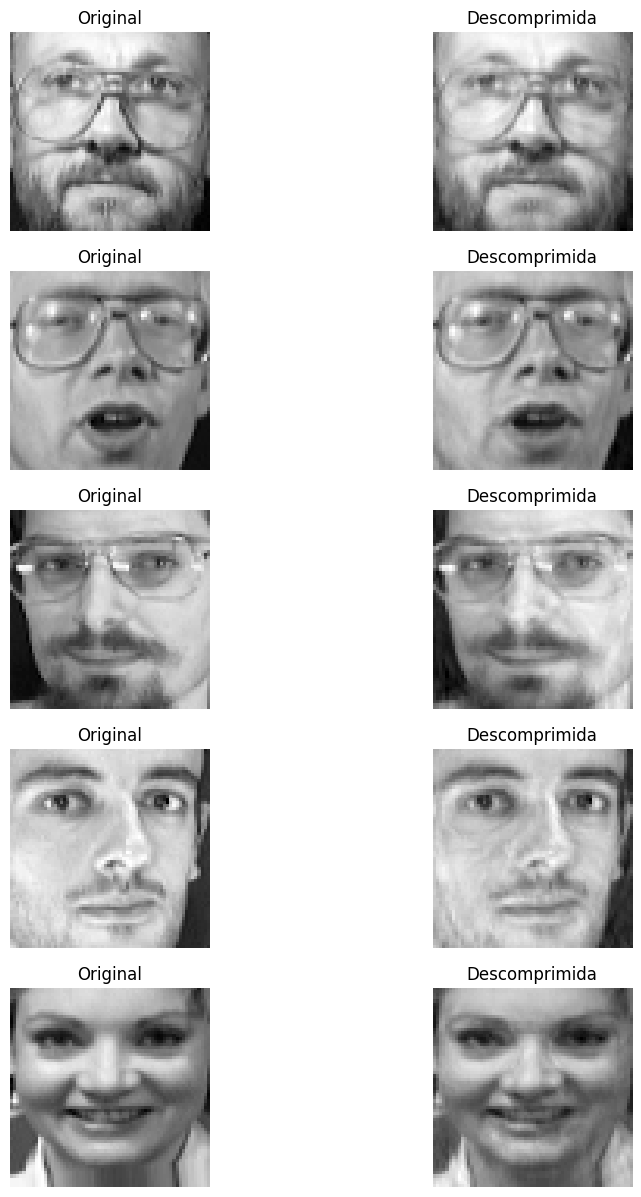

Visualización para 300 componentes principales:


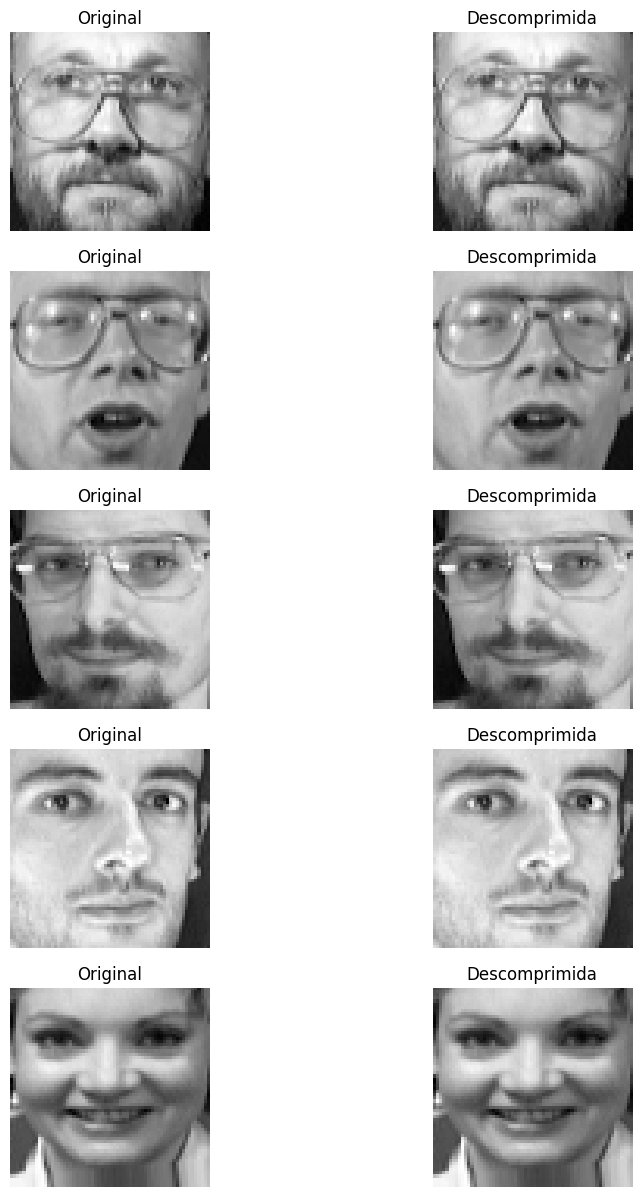

In [36]:
def plot_compressed_vs_original(X, pca, indices):
    """
    Visualiza las caras originales y descomprimidas.
    
    :param X: Conjunto de datos original.
    :param pca: Objeto PCA entrenado.
    :param indices: Índices de las caras a visualizar.
    """
    X_compressed = pca.transform(X[indices])
    X_unzipped = pca.inverse_transform(X_compressed)
    
    fig, axes = plt.subplots(len(indices), 2, figsize=(10, 15))
    for i, idx in enumerate(indices):
        # Cara original
        axes[i, 0].imshow(X[idx].reshape(h, w), cmap='gray')
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')
        
        # Cara descomprimida
        axes[i, 1].imshow(X_unzipped[i].reshape(h, w), cmap='gray')
        axes[i, 1].set_title('Descomprimida')
        axes[i, 1].axis('off')
    
    plt.show()

# Índices de las caras a visualizar
indices = [0, 10, 20, 30, 40]

# Visualizar las caras para cada valor de número de PCAs probados
for n_components in n_components_list + [150, 300]:
    pca = PCA(n_components=n_components)
    pca.fit(X_train)
    print(f'Visualización para {n_components} componentes principales:')
    plot_compressed_vs_original(X_train, pca, indices)